# Classification Problem

## General Report

The imbalance of multiple classes posed a major issue in this effort. Having 86 genre labels, many with single examples, meant getting a high accuracy was unlikely. This is also a major reason for favouring models that can handle multiclass problems without OvR or OvO - which would have meant training far too many models.

Resampling techniques were considered, but found to be either cutting the already small dataset by too much or introducing entropy through addition of synthetic data. 

Linear models such as SVMs were attempted with poor results. This makes sense as the EDA revealed that data was not linearly separable - especially for this many overlapping classes. Dependant variables also hurt the prospects of using probablistic models.

A 'key genre' feature was engineered to collapse overlapping genres together. Though this helped with EDA, it made no difference to performance as it was not adding enough new information about the variation in the data.

Encoding was also an issue as a 'one-hot' approach was adding 86 sparse features.

Boosted trees gave the best results here. Our options were limited by the problem but XGBoost deals with problems like this in how it automatically re-weights imbalanced classes and fits random forests to its own errors. A small dataset with this much noise and high cardinality target is suited to powerful ensemble methods like boosted trees.

Here are some things that were attempted but did not give good enough results:

Data

- bucketing continuous features like 'year' into 'decades'
- making ordinal feature out of song rankings in order of popularity 
- removing highly correlated features
- different kinds of encoding (especially one-hot)

Model configuration
- many ensemble methods such as stacking more boosted trees, as well as models from other families
- taking differently weighted mean predictions of different models
- manipulating regularisation hyperparameters such as 'max_depth'
- Using hyperparameter tuning techniques such as GridSearch (took too long)

In [ ]:
final_competition_score = 0.518

In [4]:
#importing libraries 

#basic libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

#plotting libraries
import matplotlib
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns

#machine learning libraries 
import xgboost as xgb

## Exploring the Data

In [5]:
#loading data
c_data = pd.read_csv('CS98XClassificationTrain.csv')
c_data_test = pd.read_csv('CS98XClassificationTest.csv')

In [6]:
#looking at rows/columns 
column_names = [x for x in c_data.columns]

c_columns = len(c_data.columns)
c_rows = len(c_data)

print('We have {} columns and {} rows in our regression training dataframe.'.format(c_columns, c_rows))

#Looking at general information
print('\nSome general information about the dataframe: ')
training_dataframe_info = c_data.info()

We have 15 columns and 453 rows in our regression training dataframe.

Some general information about the dataframe: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   year       453 non-null    int64 
 4   bpm        453 non-null    int64 
 5   nrgy       453 non-null    int64 
 6   dnce       453 non-null    int64 
 7   dB         453 non-null    int64 
 8   live       453 non-null    int64 
 9   val        453 non-null    int64 
 10  dur        453 non-null    int64 
 11  acous      453 non-null    int64 
 12  spch       453 non-null    int64 
 13  pop        453 non-null    int64 
 14  top genre  438 non-null    object
dtypes: int64(12), object(3)
memory usage: 53.2+ KB


The info method shows us the column names and data types for each column. The Non-Null count for 'top genre' is also lower than the other columns, so we will have to deal with missing values there.

Our first important observation is that there is a relatively high ratio of features to instances - and that we don't have many instances to learn from in the first place. We may need to think about models that work well with low amounts of higher-dimensional data, and about being selective with features we want to use.

In [7]:
#Looking at the train/test split
print('We have {} rows in the training sets.\n'.format(len(c_data)))
print('We have {} rows in the testing sets.\n'.format(len(c_data_test)))
data_total = c_rows + len(c_data_test)
train_split = (c_rows/data_total)*100
test_split = (100 - train_split)

print('The train/test split is about {:.2f}%/{:.2f}%'.format(train_split, test_split))

We have 453 rows in the training sets.

We have 113 rows in the testing sets.

The train/test split is about 80.04%/19.96%


## Missing Data/Values

In [8]:
#looking for how many values are missing, as well as which columns have the NaNs
n_missing = c_data.isnull().sum().sum()
genre_missing = c_data['top genre'].isnull().sum().sum()

print('Are there only missing "top genre" values?',genre_missing == n_missing)

print('We have {} values missing from the training data.'.format(n_missing))

Are there only missing "top genre" values? True
We have 15 values missing from the training data.


In [9]:
#let's look at those rows closely
missing_genres = c_data.loc[c_data['top genre'].isnull() == True]
missing_genres

,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top genre
1,2,Unchained Melody,The Teddy Bears,2011,114,44,53,-8,13,47,139,49,3,37,NaN
8,9,Someone Elses Roses,Joan Regan,2019,100,14,29,-10,15,32,143,89,3,34,NaN
26,27,Drinks On The House,Green Martini Keys,2016,97,16,57,-16,11,15,181,100,5,28,NaN
72,73,Pachuko Hop,Ike Carpenter Orchestra,2006,83,53,48,-9,34,80,135,59,3,28,NaN
90,91,Little Things Means A Lot,Jayne Mansfield,2008,109,29,70,-15,16,63,172,36,4,29,NaN
98,99,The Lady Is A Tramp,Mel Torme & the Mel-Tones,2016,138,60,41,-8,41,54,170,81,6,40,NaN
220,221,If I Give My Heart To You,The Teddy Bears,2011,113,29,49,-10,12,29,118,86,3,40,NaN
252,253,Happy Days And Lonely Nights,Suzi Miller And Johnson Brothers,2012,142,38,65,-8,13,69,146,43,3,27,NaN
265,266,Stairway Of Love,Terry Dene,2015,93,62,62,-7,25,86,120,55,4,27,NaN
266,267,You,Ten Sharp,1991,174,90,41,-8,19,67,273,43,3,61,NaN


We dropped these rows at first, but later found that losing rows hurts model accuracy with a training set this small - so instead we replaced them with the modal value - 'adult standards'.

In [10]:
modal_value = c_data['top genre'].mode()

print('The modal value for "top genre is: ', modal_value)

c_data.loc[c_data['top genre'].isnull() == True, "top genre"] = modal_value[0]

print('\nChecking row from missing data:')
print(c_data.loc[c_data['Id'] == 9])


The modal value for "top genre is:  0    adult standards
dtype: object

Checking row from missing data:
   Id                title      artist  year  bpm  nrgy  dnce  dB  live  val  \
8   9  Someone Elses Roses  Joan Regan  2019  100    14    29 -10    15   32   

   dur  acous  spch  pop        top genre  
8  143     89     3   34  adult standards  


## Exploratory Data Analysis 

### 'top genre'
We will be focusing on the target label ('top genre') and how it relates to other features.

In [11]:
genre_value_counts = c_data['top genre'].value_counts()
print(genre_value_counts)
print('\n We have 86 genre labels and they are very unbalanced.')

adult standards       83
album rock            66
dance pop             61
brill building pop    16
glam rock             16
                      ..
bow pop                1
australian rock        1
boogaloo               1
british comedy         1
alternative rock       1
Name: top genre, Length: 86, dtype: int64

 We have 86 genre labels and they are very unbalanced.


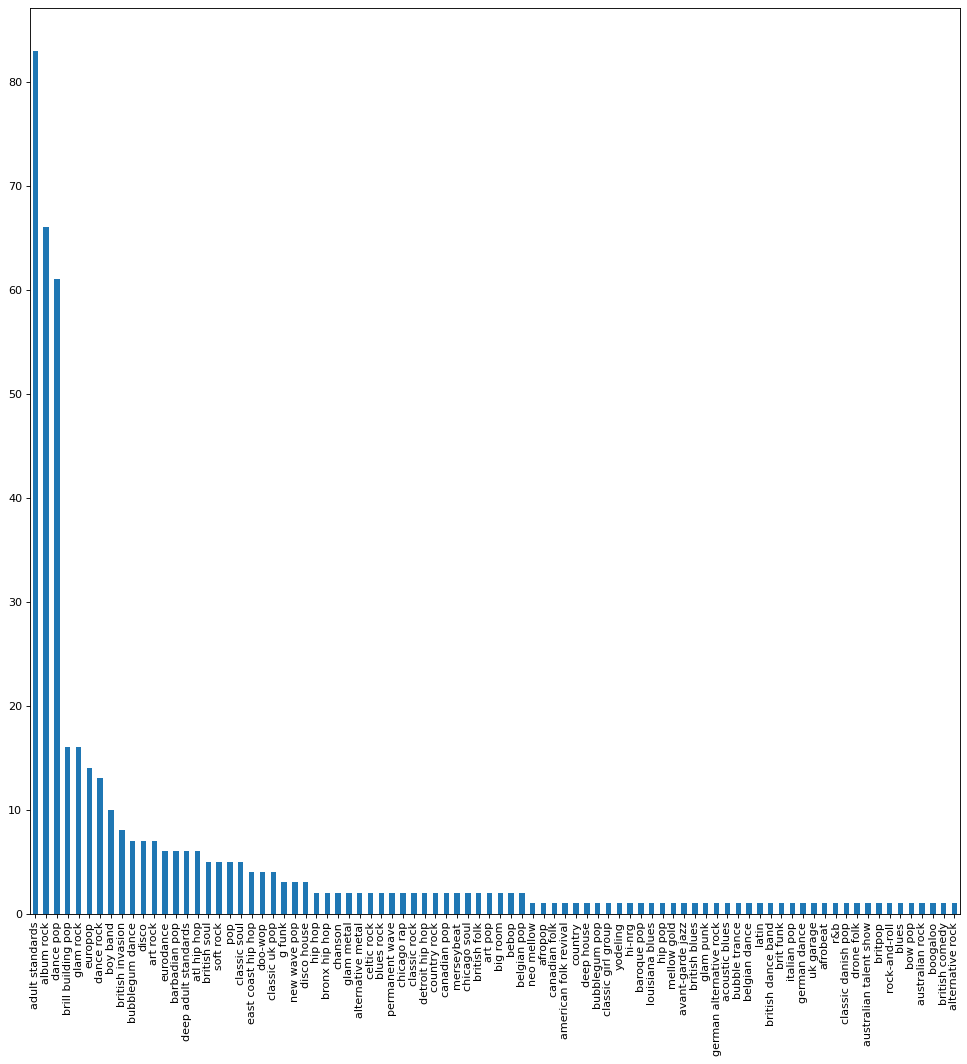

In [12]:
#looking at spread of genres
figure(num=None, figsize=(15,15), dpi=80)
genre_value_counts.plot.bar()
plt.show()

The three most represented top genres are clearly 'adult standards', 'album rock' and 'dance pop'. We have very few examples for many of the labels at the tail of the distribution. 

This will pose a problem for most classification algorithms. Methods such as resampling may be useful but with such a small dataset (around 400 rows), many of those methods are likely to contribute to overfitting. 

Class imbalance was an important factor in data preparation and model selection - we opted to explore ensemble methods that could inherently handle multi-class classification such as random forest and boosted variants which emphasise re-weighting the data when classes are uneven. 

In [13]:
#function to help describe particular genres with a given feature more closely
def describe_genre(df, genre, feature):

    just_genre = df.drop(df[df['top genre'] != genre].index, inplace = False)
    
    mean = just_genre[feature].mean()
    median = just_genre[feature].median()
    minvalue = just_genre[feature].min()
    maxvalue = just_genre[feature].max()
    variance = just_genre[feature].var()
    std = just_genre[feature].std()
    n_rows = genre_value_counts[genre]
    
    print('Summary stats for {}:\n'.format(genre))
    
    print('Mean {} for {}: {:.2f}'.format(feature, genre, mean))
    print('Median {} for {} {:.2f}'.format(feature, genre, median))
    print('Min Value of {} for {}: {:.2f}'.format(feature, genre, minvalue))
    print('Max Value of {} for {}: {:.2f}'.format(feature, genre, maxvalue))
    print('Variance of {} for {}: {:.2f}'.format(feature, genre, variance))
    print('Standard Deviation of {} for {}: {:.2f}'.format(feature, genre, std))
    print('Number of instances in this genre: {}\n'.format(n_rows))

let's look at an example of over-represented (adult standards) and under-represented (yodeling) genres.


In [14]:
#adult standards and popularity score
describe_genre(c_data, 'adult standards', 'pop')

#yodeling and popularity score
describe_genre(c_data, 'classic rock', 'pop')

Summary stats for adult standards:

Mean pop for adult standards: 51.81
Median pop for adult standards 53.00
Min Value of pop for adult standards: 26.00
Max Value of pop for adult standards: 78.00
Variance of pop for adult standards: 187.60
Standard Deviation of pop for adult standards: 13.70
Number of instances in this genre: 83

Summary stats for classic rock:

Mean pop for classic rock: 65.50
Median pop for classic rock 65.50
Min Value of pop for classic rock: 56.00
Max Value of pop for classic rock: 75.00
Variance of pop for classic rock: 180.50
Standard Deviation of pop for classic rock: 13.44
Number of instances in this genre: 2



In this example, classic rock looks more popular, but we have far less samples of classic rock songs, so sampling bias may be affecting our results. This is part of why we decided to engineer a new 'keyword genre' feature to make EDA much easier and more interpretable. 

# Feature Engineering

## Keyword Genres

For feature engineering we collapsed the given genre labels into larger subsets using keywords such as 'pop' and 'rock'. This approach will helped with EDA, as genres that are closely related by keyword can be analysed together as a family of labels. EDA otherwise produced difficult to interpret visualisations.

Over-represented genre labels like 'adult standards' will be kept, but many that don't include keywords will be put into the 'other' keyword category. 

In [15]:
top_genres = list(c_data['top genre'].unique())

print('We will refer to these as "label genre":\n{}...'.format( top_genres[:15]))

We will refer to these as "label genre":
['adult standards', 'glam rock', 'pop', 'album rock', 'boy band', 'brill building pop', 'rock-and-roll', 'country rock', 'canadian pop', 'dance pop', 'europop', 'bebop', 'art rock', 'disco', 'blues']...


In [16]:
#setting up the new labels based on keywords
genre_keywords = ['adult standards', 'boy band','rock', 'dance', 'pop', 'hip hop', 'blues', 'folk', 'soul','disco']

#adding the new column to a copy of the dataframe
c_data_extra = copy.deepcopy(c_data)
c_data_extra['key genre'] = 'Other'

#getting list of genre label values
top_genre_data = list(c_data_extra['top genre'].values)

#resetting index for safety when using enumerate
c_data_extra = c_data_extra.reset_index()

#loop through label value array and add value to key genres if keyword present in label
for i,row_value in enumerate(top_genre_data):
    for key in genre_keywords:
        if key in row_value:
            c_data_extra.at[i,'key genre']= key

#look at slice of df to see if it worked
c_data_extra[5:10]

,index,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top genre,key genre
5,5,6,Grenade,Bruno Mars,2010,110,56,71,-7,12,23,223,15,6,74,pop,pop
6,6,7,No Time,The Guess Who,1971,128,48,48,-14,5,12,219,8,6,44,album rock,rock
7,7,8,End Of The Road,Boyz II Men,1991,150,43,64,-9,6,53,351,7,2,71,boy band,boy band
8,8,9,Someone Elses Roses,Joan Regan,2019,100,14,29,-10,15,32,143,89,3,34,adult standards,adult standards
9,9,10,You Belong to My Heart,Timi Yuro,2013,108,39,46,-10,16,50,126,82,3,35,adult standards,adult standards


In [17]:
#value counts for new column 
kw_genre_value_counts = c_data_extra['key genre'].value_counts()
print(kw_genre_value_counts)

pop                123
rock               104
adult standards     89
Other               49
dance               29
hip hop             16
soul                12
boy band            10
disco               10
blues                6
folk                 5
Name: key genre, dtype: int64


Note: We removed keywords that were capturing less than 5 labels each so that we don't have sparse classes to use for EDA.

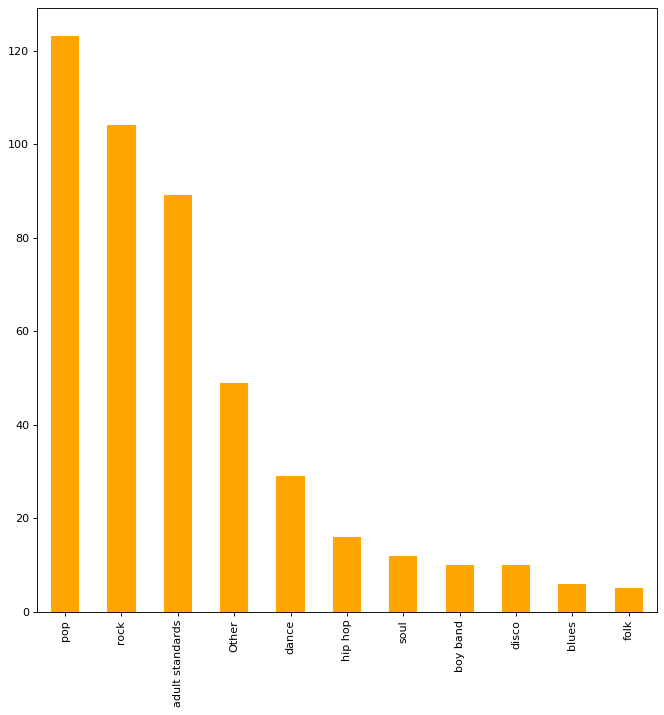

In [18]:
#spread of keyword genres
figure(num=None, figsize=(10,10), dpi=80)
kw_genre_value_counts.plot.bar(color = 'orange')
plt.show()

The spread of genres is still skewed, but fewer categories will make EDA much easier.

We can now use different plots to see how linearly separable the data is, as well as which features can help distinguish genres in general - hopefully they will carry over to the more specific genre labels. 

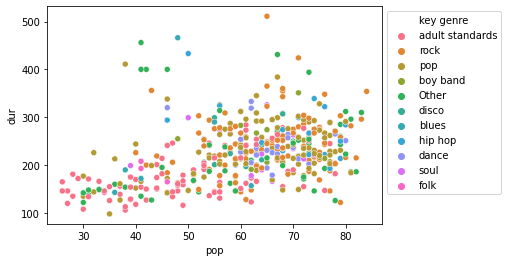

In [19]:
#don't know whether to keep this or to find better scatterplot
ax = sns.scatterplot(data=c_data_extra,x=c_data_extra['pop'], y=c_data_extra['dur'], hue = 'key genre', legend = True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Even with collapsed genres, the data is far from linearly separable.

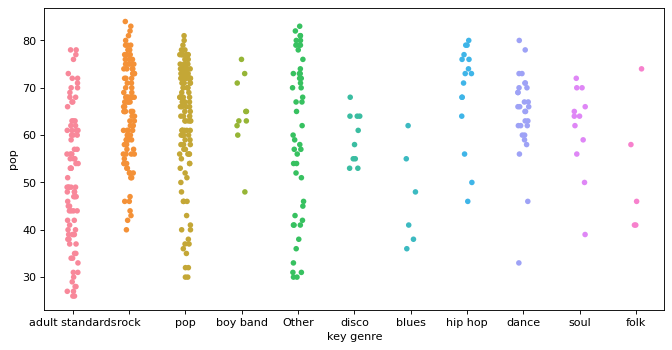

In [20]:
#popularity scores for genres
figure(num=None, figsize=(10,5), dpi=80)
sns.stripplot(x=c_data_extra['key genre'], y=c_data_extra['pop'], data=c_data_extra)
plt.show()

Strip plots show how features impact genre. There is a clear compounding of points near the top for rock and pop, showing that they are popular genres, but adult standards are more spread out in their popularity.

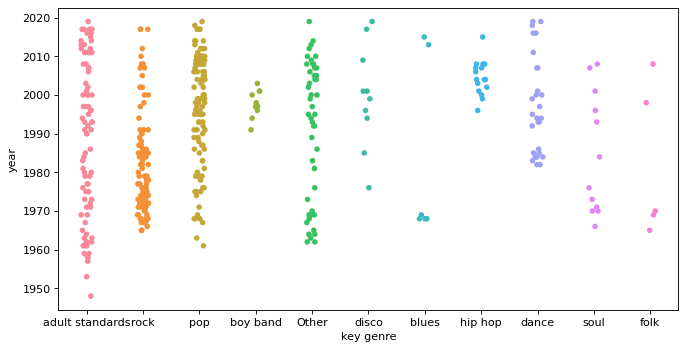

In [21]:
#plotting genre with year
figure(num=None, figsize=(10,5), dpi=80)
sns.stripplot(x=c_data_extra['key genre'], y=c_data_extra['year'], data=c_data_extra)
plt.show()

Year gives some indication for genre. Boybands are from a specific decade, but adult standards are very spread. This plot shows that there are many outliers in other genres, however. 

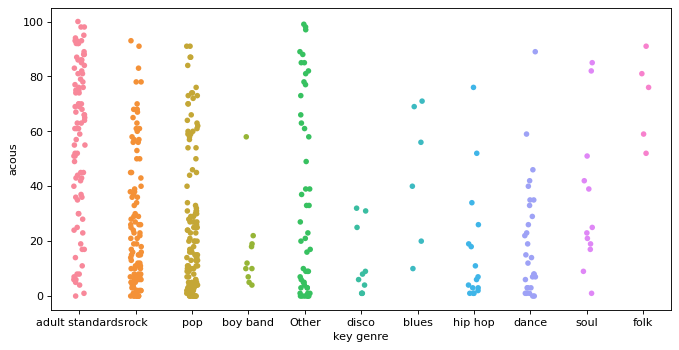

In [23]:
figure(num=None, figsize=(10,5), dpi=80)
sns.stripplot(x=c_data_extra['key genre'], y=c_data_extra['acous'], data=c_data_extra)
plt.show()

'acous' also has clear influence (especially for folk). Features like this are good indicators for some genres but not others. High spread in the 'other' category shows the limitation of the key genre approach.

## Data Pre-processing

Making some additional changes to the data for the training stage. In particular, we label encoded the categorical features. One-hot encoding was considered first, but it doesn't work as well for tree-based models because adding a sparse feature vector for each category means that required tree depth is increased by a large factor which introduces error. 

Many other transformations and scaling methods were applied, but better results were not achieved for this problem. There are diminishing returns on using these techniques with models like boosted trees, which are fairly resistant to skewed distributions and scales.

Below are some functions made to manipulate data more easily.

In [28]:
#importing libraries we will use

#data prep
from sklearn import preprocessing
#eval
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [29]:
def drop_columns(X_train, X_test, column_list, make_copy = False):
  #function for dropping specified rows
  if make_copy == True:
    X_train = copy.deepcopy(X_train)
    X_test = copy.deepcopy(X_test)

  X_train_dropped = X_train.drop(column_list, axis = 1)
  X_test_dropped = X_test.drop(column_list, axis = 1)

  return X_train_dropped, X_test_dropped

def train_test(train_data, test_data, target,  drop_columns, make_copy = False):
  #function for dropping columns and splitting data into X/y 
  if make_copy == True:
    train_data = copy.deepcopy(train_data)
    test_data = copy.deepcopy(test_data)
    
    y_train = train_data[target]
    X_train = train_data.drop([target], axis = 1)

    X_test = test_data.drop(drop_columns, axis = 1)
    X_train = X_train.drop(drop_columns, axis = 1)

    return X_train, y_train, X_test


def transform_features(df, columns, transformer_name, transf_dict):
  #function for scaling or normalising specified features

  if transf_dict is None:

    if transformer_name == 'Standard':
      transf = preprocessing.StandardScaler()
  
    elif transformer_name == 'MinMax':
     transf = preprocessing.MinMaxScaler()

    elif transformer_name == 'Robust':
      transf = preprocessing.RobustScaler()
  
    elif transformer_name == 'PowerTransformer':
      transf = preprocessing.PowerTransformer()
  
    #make a dictionary of the fitted transformer so that we can use training scales for testing data

    transf_dict = {}
    
    for col in columns:
      col_transf = copy.deepcopy(transf)
      col_transf = col_transf.fit(df[[col]])
      df[col] = col_transf.transform(df[[col]])
      transf_dict[col] = col_transf
	
  else:
    for col in columns:
      transf = transf_dict.get(col)
      df[col] = transf.transform(df[[col]])
    
    return df

  return df, transf_dict #returning dictionary and df with scaled features
   
def label_encoding(X, X_test, column, target = False):
  

  label_encoder = preprocessing.LabelEncoder()
  
  if target == False:
    X_train = X
    train_len = len(X_train)
    full_data = pd.concat([X_train[column], X_test[column]], axis = 0,ignore_index=True)
    full_data_enc = label_encoder.fit_transform(full_data.values)
  
    X_train_enc = full_data_enc[:train_len]
    X_test_enc = full_data_enc[train_len:]

    return X_train_enc, X_test_enc, label_encoder
  
  y_train = X
  y_train_enc = label_encoder.fit_transform(y_train)
  
  return y_train_enc, label_encoder


#for evaluation
def display_scores(scores):

  print("Scores:")

  for i,score in enumerate(scores):
    print('Fold {} - {:.3f}'.format(i, score))

  print("\nMean: {:.3f}".format(scores.mean()))
  print("Standard deviation: {:.3f}".format(scores.std()))
  print('\n')

def learning_curve(model, X, y, xgb = False):

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)
  train_errors, val_errors = [], []

  if xgb == True:
    y_train = y_train.values.ravel()

  for m in range(1, X_train.shape[0]):
      model.fit(X_train[:m], y_train[:m])
      y_train_predict = model.predict(X_train[:m])
      y_val_predict = model.predict(X_val)
      train_errors.append(accuracy_score(y_train[:m],y_train_predict))
      val_errors.append(accuracy_score(y_val, y_val_predict))

  plt.plot(train_errors, "r-+", linewidth=2, label="train")
  plt.plot(val_errors, "b-", linewidth=3, label="val")
  
def plot_learning_curve(model, X, y, xgb = False):

  plt.figure(figsize=(6,4), dpi=120)
  learning_curve(model, X, y, xgb = xgb)
  plt.ylim(top=1);
  plt.legend();
  plt.xlabel('Training set size');
  plt.ylabel('Accuracy');

In [30]:
#data setup 
dropping_columns = ['Id', 'title']
target = 'top genre'

X_train, y_train, X_test = train_test(c_data, c_data_test, target,  dropping_columns, make_copy = True)


In [31]:
#data prep 

#artist encoding
train_artist_enc, test_artist_enc, artist_encoder = label_encoding(X_train, X_test, 'artist', target = False)

X_train['artist'] = train_artist_enc
X_test['artist'] = test_artist_enc

#top genre encoding
y_train_genre_enc, genre_encoder = label_encoding(y_train, None, 'top genre', target = True)
y_train_enc = pd.DataFrame(y_train_genre_enc, index = y_train.index)


#Power Transforming conitnuous data
cont_data = ['year', 'bpm',	'nrgy',	'dnce',	'dB',	'live',	'val', 'dur',	'acous', 'spch', 'pop']

X_train, powertf_dict = transform_features(X_train, cont_data, 'PowerTransformer', transf_dict = None)
X_test = transform_features(X_test, cont_data, 'PowerTransformer', transf_dict = powertf_dict)


### Dummy model

In [32]:
#model fitting and prediction
dummy_clf = DummyClassifier(random_state = 42)
dummy_clf.fit(X_train, y_train_enc)

y_dummy_eval = dummy_clf.predict(X_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Cross Validation
Scores:
Fold 0 - 0.196
Fold 1 - 0.196
Fold 2 - 0.196
Fold 3 - 0.178
Fold 4 - 0.178
Fold 5 - 0.178
Fold 6 - 0.178
Fold 7 - 0.178
Fold 8 - 0.178
Fold 9 - 0.178

Mean: 0.183
Standard deviation: 0.008


The training accuracy of Dummy Classifier is: 0.183

Learning Curve for Dummy model:



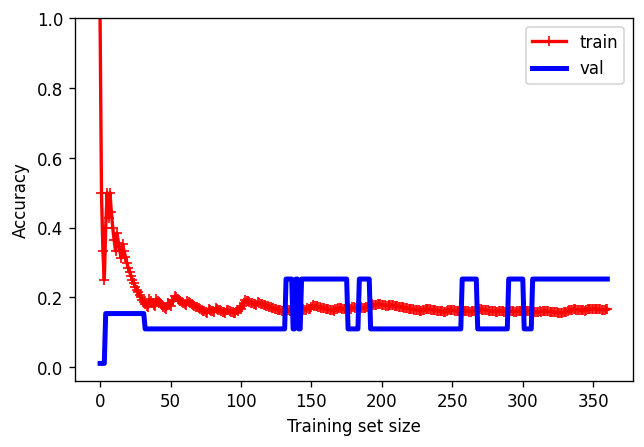

In [33]:
#model evaluation
dummy_acc = accuracy_score(y_dummy_eval, y_train_enc)


dummy_cv_scores = cross_val_score(dummy_clf, X_train, y_train_enc,
scoring="accuracy", cv=10)

print('Cross Validation')
display_scores(dummy_cv_scores)


print('The training accuracy of Dummy Classifier is: {:.3f}\n'.format(dummy_acc))

#plotting the learning curve

print('Learning Curve for Dummy model:\n')

plot_learning_curve(dummy_clf, X_train, y_train_enc)

Results are as expected of a random classifier.

### Baseline Model

We will use a one-versus-rest classifier comprised of logistic regression models.


In [34]:
#model fitting and prediction
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train_enc)

y_dt_eval = dt_clf.predict(X_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Cross Validation
Scores:
Fold 0 - 0.174
Fold 1 - 0.174
Fold 2 - 0.217
Fold 3 - 0.244
Fold 4 - 0.267
Fold 5 - 0.067
Fold 6 - 0.222
Fold 7 - 0.156
Fold 8 - 0.311
Fold 9 - 0.178

Mean: 0.201
Standard deviation: 0.064


The training accuracy of Decision Trees is: 1.000

Learning Curve for baseline model:



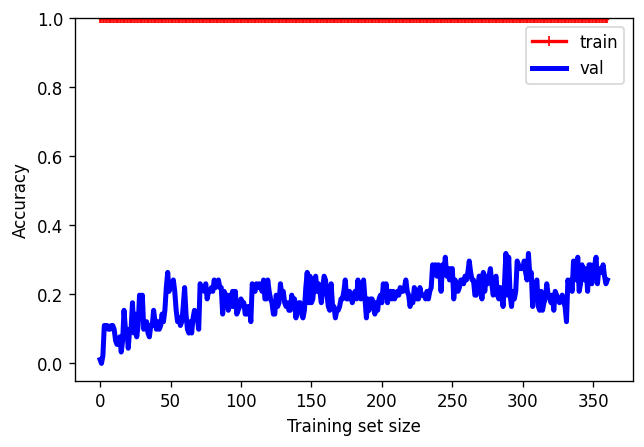

In [35]:
#model evaluation
dt_acc = accuracy_score(y_dt_eval, y_train_enc)


dt_cv_scores = cross_val_score(dt_clf, X_train, y_train_enc,
scoring="accuracy", cv=10)

print('Cross Validation')
display_scores(dt_cv_scores)

print('The training accuracy of Decision Trees is: {:.3f}'.format(dt_acc))

#plotting the learning curve

print('\nLearning Curve for baseline model:\n')

plot_learning_curve(dt_clf, X_train, y_train_enc)

DTs show much more overfitting than XGBoost. The difference shows that though they are of the same family, the randomised and ensemble aspects of XGBoost makes up for at least some overfitting issues.

### XGB Model Fitting

In [36]:
#model fitting and prediction
xgb_clf = xgb.XGBClassifier(sample_type = 'weighted', num_class = 86)
xgb_clf.fit(X_train, y_train_enc.values.ravel(), eval_metric = 'merror')
           
y_pred_enc = xgb_clf.predict(X_test)

#unencoding predictions for upload
y_pred = genre_encoder.inverse_transform(y_pred_enc)


In [37]:
#model evaluation
y_eval = xgb_clf.predict(X_train)

xgb_acc = accuracy_score(y_train_enc,y_eval)

xgb_cv_scores = cross_val_score(xgb_clf, X_train, y_train_enc.values.ravel(),
scoring="accuracy", cv=10)
print('Cross Validation')
display_scores(xgb_cv_scores)

print('The training accuracy of XGBoost is: {:.3f}'.format(xgb_acc))
print('The testing accuracy of XGBoose is: 0.518\n')

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Cross Validation
Scores:
Fold 0 - 0.391
Fold 1 - 0.413
Fold 2 - 0.413
Fold 3 - 0.400
Fold 4 - 0.422
Fold 5 - 0.378
Fold 6 - 0.311
Fold 7 - 0.378
Fold 8 - 0.422
Fold 9 - 0.356

Mean: 0.388
Standard deviation: 0.033


The training accuracy of XGBoost is: 0.936
The testing accuracy of XGBoose is: 0.518




Learning Curve for XGBoost model:



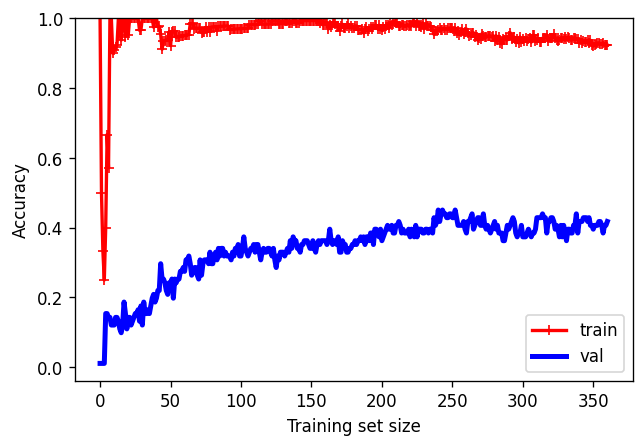

In [38]:
#plotting the learning curve - warning: this cell can take around 4-5 minutes to plot the learning curve

print('\nLearning Curve for XGBoost model:\n')

plot_learning_curve(xgb_clf, X_train, y_train_enc, xgb = True)

Learning curve shows severe overfitting. Though learning curves for this problem are less reliable as models are trained on subsets that will not contain any examples from testing of genres that have only one instance.

### Comparisons

[Text(0, 0.5, ' Training accuracy'), Text(0.5, 0, 'Model')]

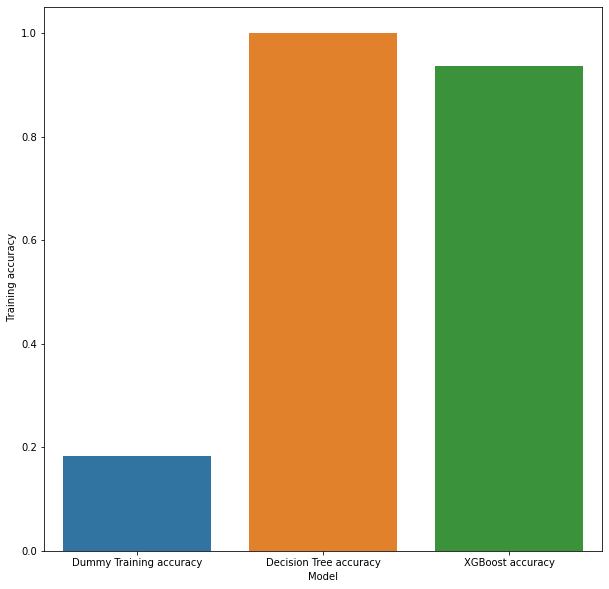

In [45]:
training_accuracy = [dummy_acc, dt_acc, xgb_acc]
training_accuracy = pd.DataFrame({'Dummy Training accuracy':dummy_acc, 'Decision Tree accuracy':dt_acc, 'XGBoost accuracy':xgb_acc}, index = training_accuracy)

fig, ax = plt.subplots(figsize = (10,10))
sns.barplot(data = training_accuracy)
ax.set(xlabel='Model', ylabel=' Training accuracy')



Though DTs seem to perform best, this is accuracy on the training data only. DT must have fit to training data almost perfectly and has memorised it.

Text(0.5, 0, 'Average CV Accuracy')

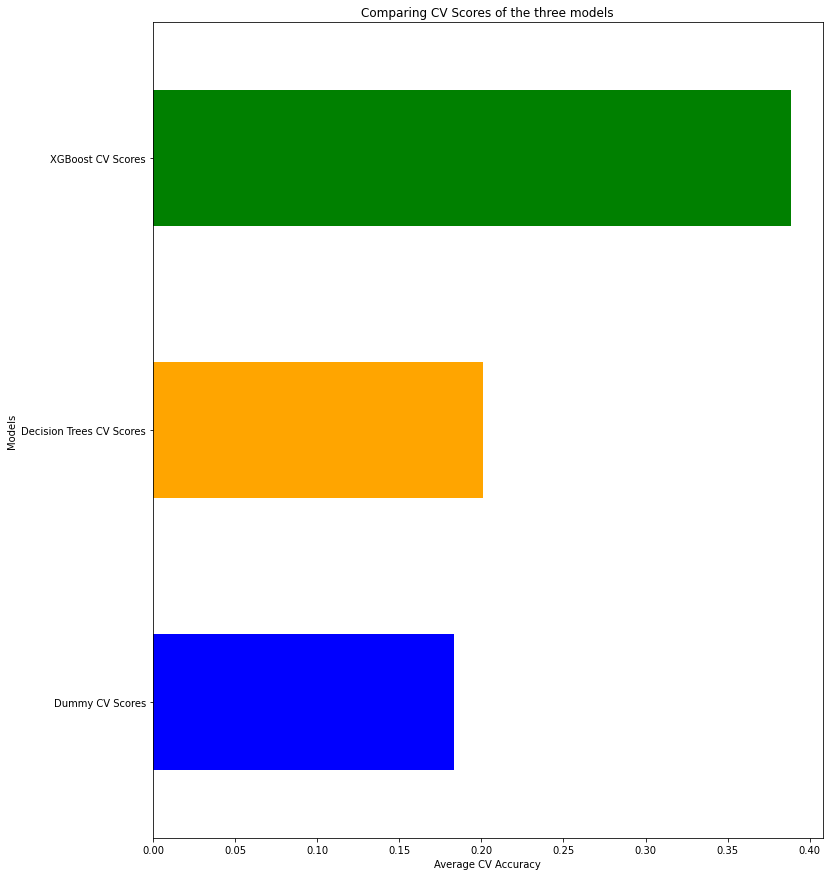

In [44]:
cv_comparison_data = pd.DataFrame({'Dummy CV Scores':dummy_cv_scores, 'Decision Trees CV Scores':dt_cv_scores, 'XGBoost CV Scores':xgb_cv_scores}, index = range(1,11))

cv_comparison_data.mean().plot.barh(title = 'Comparing CV Scores of the three models', figsize = (12,15), xlabel = 'Models', ylabel = 'Accuracy', color = ['blue', 'orange', 'green'])
plt.xlabel('Average CV Accuracy')

Average CV scores give XGBoost the obvious edge, but accuracy is still below half for the most part - lower than score in competition standings. Accuracy is likely to decrease as testing size increases.

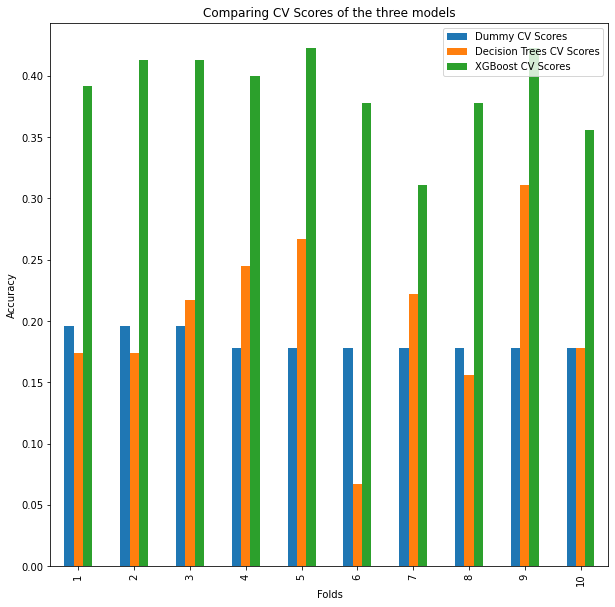

In [40]:
cv_comparison_data = pd.DataFrame({'Dummy CV Scores':dummy_cv_scores, 'Decision Trees CV Scores':dt_cv_scores, 'XGBoost CV Scores':xgb_cv_scores}, index = range(1,11))

cv_comparison_data.plot(kind = 'bar', title = 'Comparing CV Scores of the three models', figsize = (10,10), xlabel = 'Folds', ylabel = 'Accuracy')


XGBoost performs best on all folds, but is not consistent as can be seen in fold 7. Again, a sign of overfitting.

## Final Model Evaluation

- such an unbalanced dataset is going to lead to really bad cross validation scores

- look at how many times it predicts 'adult genre' and 'album rock'. A biased sample has led to overfitting. This can be seen from the difference in training and testing accuracy too. 

## Conclusions

Looking at the actual predictions the model makes, there is a clear over-representation of 'adult standards' and 'album rock' labels. Though these are likely genres with many examples, they are likely over-represented in the training data, especially in comparison to genres with single instances. The training data likely exhibits a biased sample.

The single instance problem makes getting a high accuracy unlikely, as any ML model needs at least a few examples to learn the underlying structure of classes. The kaggle competition standings reflect this, with many of the best results only reaching slightly above 50% accuracy.

More musical features of songs would likely have made for better results as well, as information such as the 'key' or time signature of a song are better defined instrinsic aspects of genre definition.

In the end, the data imbalance made options limited, but boosted trees gave the best results because of how they offset imbalance with sample weighting.  

## Reflections

With more data, resampling methods would probably have been the most promising avenue for increasing accuracy. We considered, however, that perhaps a delicate balance could have been struck that would allow us to add or remove instances with minimal impact on accuracy.

More time should have been spent on regularisation of XGBoost. It's training performance was so high that trading some variance for bias would probably have led to the best results.

In future efforts, more attention will be payed to focusing on models that can deal with high cardinality multiclass problems reasonably well, and not OvR or OvO models that are extremely time consuming with datasets like this.

There may have also been better features to engineer that would highlight important relationships in the data and provide the model with more information as to which features give a good indication of genre.

### Uploading Predictions

In [41]:
predictions = pd.DataFrame(data = y_pred, columns = ['top genre'])

id = pd.DataFrame(data = c_data_test['Id'], columns = ['Id'])
predictions = pd.merge(id, predictions, right_index = True, left_index = True)

predictions


# predictions.to_csv('spotify_classification.csv', index=False)

,Id,top genre
0,454,dance pop
1,455,glam rock
2,456,glam rock
3,457,dance pop
4,458,adult standards
...,...,...
108,563,europop
109,564,dance pop
110,565,east coast hip hop
111,566,atl hip hop
